<a href="https://colab.research.google.com/github/hibadash/-Breast-Ultrasound-Classification-Using-Xception-CNN-BUSI-Dataset/blob/ModelTraining/notebooks/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 02 — Entraînement du modèle Xception

Ce notebook contient le code complet pour entraîner le modèle Xception CNN sur le dataset BUSI.

## Objectifs:
- Charger et préparer les données
- Configurer les hyperparamètres (learning rate, batch size, epochs)
- Entraîner le modèle avec callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
- Visualiser les résultats d'entraînement
- Sauvegarder le meilleur modèle

In [2]:
import shutil, os
if os.path.exists("breast_project"):
    shutil.rmtree("breast_project")

In [3]:
!git clone https://github.com/hibadash/-Breast-Ultrasound-Classification-Using-Xception-CNN-BUSI-Dataset.git breast_project

import os
os.chdir("breast_project")
print("Répertoire courant :", os.getcwd())

Cloning into 'breast_project'...
remote: Enumerating objects: 5475, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 5475 (delta 36), reused 7 (delta 2), pack-reused 5393 (from 2)
Receiving objects: 100% (5475/5475), 338.68 MiB | 33.85 MiB/s, done.
Resolving deltas: 100% (281/281), done.
Updating files: 100% (4107/4107), done.
Répertoire courant : /content/breast_project


In [4]:
# Installer les dépendances si nécessaire
!pip install -q tensorflow>=2.15 numpy pandas matplotlib seaborn scikit-learn

In [ ]:
import sys
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    CSVLogger,
    TensorBoard,
    Callback
)
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Afficher les versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Vérifier la disponibilité du GPU
print(f"\nGPU disponible: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté")
else:
    print("Pas de GPU")

TensorFlow version: 2.19.0
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU détecté


In [ ]:
# =======================
# HYPERPARAMÈTRES D'ENTRAÎNEMENT
# =======================

# Hyperparamètres principaux
LEARNING_RATE = 1e-4  # Taux d'apprentissage initial
BATCH_SIZE = 32        # Taille du batch
EPOCHS = 50            # Nombre maximum d'epochs
IMAGE_SIZE = (224, 224)  # Taille des images
SEED = 42

# Callbacks
PATIENCE_EARLY_STOPPING = 12  # Arrêt anticipé si pas d'amélioration
PATIENCE_LR_REDUCTION = 6     # Réduction du LR si pas d'amélioration

# Fine-tuning (optionnel)
FINE_TUNE_AFTER_EPOCHS = 6    # Commencer le fine-tuning tôt
FINE_TUNE_LEARNING_RATE = 1e-5  # LR plus faible pour fine-tuning

# Chemins
data_root = 'data/Dataset_BUSI'
RESULTS_DIR = 'results'
MODEL_SAVE_PATH = os.path.join(RESULTS_DIR, 'model_xception_best.h5')
MODEL_FINAL_PATH = os.path.join(RESULTS_DIR, 'model_xception_final.h5')

# Créer le dossier results
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Configuration chargée!")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Epochs max: {EPOCHS}")
print(f"   - Early stopping patience: {PATIENCE_EARLY_STOPPING}")
print(f"   - Fine-tuning après: {FINE_TUNE_AFTER_EPOCHS} epochs")

Configuration chargée!
   - Learning rate: 0.0001
   - Batch size: 32
   - Epochs max: 50
   - Early stopping patience: 10


In [ ]:
# =======================
# Fonctions utilitaires
# =======================

def set_global_seed(seed: int):
    """Initialise de manière déterministe toutes les librairies utilisées."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def compute_balanced_class_weights(generator):
    """Calcule les poids de classe équilibrés à partir d'un générateur Keras."""
    class_ids = np.arange(len(generator.class_indices))
    weights = compute_class_weight(class_weight='balanced', classes=class_ids, y=generator.classes)
    return {idx: float(weight) for idx, weight in zip(class_ids, weights)}


class FineTuneCallback(Callback):
    """Callback pour déclencher le fine-tuning au bon moment."""

    def __init__(self, unfreeze_epoch: int):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self._has_unfroze = False

    def on_epoch_begin(self, epoch, logs=None):
        if not self._has_unfroze and (epoch + 1) == self.unfreeze_epoch:
            unfreeze_model_for_fine_tuning(self.model, epoch + 1)
            self._has_unfroze = True


def unfreeze_model_for_fine_tuning(model, epoch):
    """Débloque certaines couches du modèle de base pour le fine-tuning."""
    if epoch == FINE_TUNE_AFTER_EPOCHS:
        print(f"\n DÉBUT DU FINE-TUNING (Epoch {epoch})")
        print("    Déblocage des dernières couches de Xception...")

        base_model = model.layers[0]
        base_model.trainable = True

        # Geler les premières couches et ne garder que les 50 dernières couchées entraînables
        for layer in base_model.layers[:-50]:
            layer.trainable = False

        model.compile(
            optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
            metrics=['accuracy']
        )

        print(f" Learning rate réduit à: {FINE_TUNE_LEARNING_RATE}")
        print(f" Couches débloquées: {sum(1 for l in base_model.layers if l.trainable)}/{len(base_model.layers)}")
        print()

## Préparation des données

In [7]:
# Vérifier le chemin du dataset AVANT d'importer preprocess.py
import os
print(f"   Vérification du dataset...")
print(f"   Répertoire courant: {os.getcwd()}")
print(f"   Chemin dataset: {DATASET_DIR}")
print(f"   Dataset existe? {os.path.exists(DATASET_DIR)}")

# Importer les générateurs de données depuis preprocess.py
from data.preprocess import (
    train_generator,
    val_generator,
    test_generator
)

# Afficher les informations sur le dataset
print(" INFORMATIONS SUR LE DATASET")
print("="*60)
print(f"Images d'entraînement: {train_generator.samples}")
print(f"Images de validation: {val_generator.samples}")
print(f"Images de test: {test_generator.samples}")
print(f"\nClasses: {sorted(list(train_generator.class_indices.keys()))}")
print(f"Mapping des classes: {train_generator.class_indices}")
print(f"Taille des images: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60)


   Vérification du dataset...
   Répertoire courant: /content/breast_project
   Chemin dataset: data/Dataset_BUSI
   Dataset existe? True
Found 3615 images belonging to 3 classes.
Found 236 images belonging to 3 classes.
Found 237 images belonging to 3 classes.
Préprocessing prêt : train, validation et test chargés !
 INFORMATIONS SUR LE DATASET
Images d'entraînement: 3615
Images de validation: 236
Images de test: 237

Classes: ['benign', 'malignant', 'normal']
Mapping des classes: {'benign': 0, 'malignant': 1, 'normal': 2}
Taille des images: (224, 224)
Batch size: 32


## Construction du modèle Xception

In [8]:
# Importer la fonction de création du modèle
from src.model import load_xception_model

# Créer le modèle
num_classes = len(train_generator.class_indices)
print(f"Création du modèle Xception pour {num_classes} classes...")

model = load_xception_model(
    input_shape=(*IMAGE_SIZE, 3),
    num_classes=num_classes,
    trainable=False
)
# Recompiler avec sparse_categorical_crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle créé avec succès!")
print(f"\n Statistiques du modèle:")
print(f"   - Paramètres totaux: {model.count_params():,}")
print(f"   - Paramètres entraînables: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Afficher un résumé du modèle
model.summary()

Création du modèle Xception pour 3 classes...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Modèle créé avec succès!

 Statistiques du modèle:
   - Paramètres totaux: 22,045,739
   - Paramètres entraînables: 1,182,723


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,045,739 (84.10 MB)

 Trainable params: 1,182,723 (4.51 MB)

 Non-trainable params: 20,863,016 (79.59 MB)

## Configuration des callbacks

In [9]:
# Créer tous les callbacks nécessaires
callbacks = [
    # 1. Sauvegarde du meilleur modèle
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),

    # 2. Early Stopping
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=PATIENCE_EARLY_STOPPING,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),

    # 3. Réduction automatique du learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,  # Réduire le LR de moitié
        patience=PATIENCE_LR_REDUCTION,
        min_lr=1e-7,
        verbose=1
    ),

    # 4. Logger CSV
    CSVLogger(
        filename=os.path.join(RESULTS_DIR, 'training_log.csv'),
        separator=',',
        append=False
    ),

    # 5. TensorBoard (pour Colab, on peut utiliser TensorBoard.dev)
    TensorBoard(
        log_dir=os.path.join(RESULTS_DIR, 'tensorboard_logs'),
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
]

print(f" {len(callbacks)} callbacks configurés:")
print("   1. ModelCheckpoint - Sauvegarde du meilleur modèle")
print("   2. EarlyStopping - Arrêt anticipé")
print("   3. ReduceLROnPlateau - Réduction du learning rate")
print("   4. CSVLogger - Log des métriques")
print("   5. TensorBoard - Visualisation avancée")


 5 callbacks configurés:
   1. ModelCheckpoint - Sauvegarde du meilleur modèle
   2. EarlyStopping - Arrêt anticipé
   3. ReduceLROnPlateau - Réduction du learning rate
   4. CSVLogger - Log des métriques
   5. TensorBoard - Visualisation avancée


In [11]:
# Calculer les steps par epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*60)
print(f"Steps par epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print("="*60)
print()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy', # FIX: Changed from sparse_categorical_crossentropy
    metrics=['accuracy']
)

# Lancer l'entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n ENTRAÎNEMENT TERMINÉ!")

DÉBUT DE L'ENTRAÎNEMENT
Steps par epoch: 112
Validation steps: 7

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6425 - loss: 1.0057

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.77679, saving model to results/model_xception_best.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 117s 795ms/step - accuracy: 0.6432 - loss: 1.0038 - val_accuracy: 0.7768 - val_loss: 0.5988 - learning_rate: 1.0000e-04
Epoch 2/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.7500 - loss: 0.7480

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.77679 to 0.78125, saving model to results/model_xception_best.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7500 - loss: 0.7480 - val_accuracy: 0.7812 - val_loss: 0.5946 - learning_rate: 1.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.7866 - loss: 0.5840
Epoch 3: val_accuracy did not improve from 0.78125
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.7866 - loss: 0.5838 - val_accuracy: 0.7500 - val_loss: 0.5257 - learning_rate: 1.0000e-04
Epoch 4/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.6562 - loss: 0.8034
Epoch 4: val_accuracy did not improve from 0.78125
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.6562 - loss: 0.8034 - val_accuracy: 0.7500 - val_loss: 0.5269 - learning_rate: 1.0000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8145 - loss: 0.5037
Epoch 5: val_accuracy improved from 0.78125 to 0.82589, saving model to results/model_xception_best.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 573ms/step - accuracy: 0.8144 - loss: 0.5038 - val_accuracy: 0.8259 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 6/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8125 - loss: 0.5927
Epoch 6: val_accuracy did not improve from 0.82589
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8125 - loss: 0.5927 - val_accuracy: 0.8259 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8197 - loss: 0.4938
Epoch 7: val_accuracy did not improve from 0.82589
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 578ms/step - accuracy: 0.8197 - loss: 0.4937 - val_accuracy: 0.8125 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 8/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.8438 - loss: 0.4030
Epoch 8: val_accuracy did not improve from 0.82589
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8438 - loss: 0.4030 - val_accuracy: 0.8125 - val_loss: 0.4114 - learning_rate: 1.00

112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - accuracy: 0.8279 - loss: 0.4663 - val_accuracy: 0.8393 - val_loss: 0.3859 - learning_rate: 1.0000e-04
Epoch 10/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.9375 - loss: 0.2763
Epoch 10: val_accuracy did not improve from 0.83929
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9375 - loss: 0.2763 - val_accuracy: 0.8393 - val_loss: 0.3840 - learning_rate: 1.0000e-04
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8315 - loss: 0.4216
Epoch 11: val_accuracy did not improve from 0.83929
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 578ms/step - accuracy: 0.8315 - loss: 0.4217 - val_accuracy: 0.8170 - val_loss: 0.3944 - learning_rate: 1.0000e-04
Epoch 12/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.8125 - loss: 0.4706
Epoch 12: val_accuracy did not improve from 0.83929
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8125 - loss: 0.4706 - val_accuracy: 0.8170 - val_loss: 0.3998 - learning_rate

112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 579ms/step - accuracy: 0.8532 - loss: 0.3930 - val_accuracy: 0.8438 - val_loss: 0.3613 - learning_rate: 1.0000e-04
Epoch 14/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.9062 - loss: 0.2988
Epoch 14: val_accuracy did not improve from 0.84375
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9062 - loss: 0.2988 - val_accuracy: 0.8393 - val_loss: 0.3619 - learning_rate: 1.0000e-04
Epoch 15/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8531 - loss: 0.3872
Epoch 15: val_accuracy did not improve from 0.84375
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 733ms/step - accuracy: 0.8531 - loss: 0.3873 - val_accuracy: 0.8214 - val_loss: 0.4109 - learning_rate: 1.0000e-04
Epoch 16/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.8750 - loss: 0.4753
Epoch 16: val_accuracy did not improve from 0.84375
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8750 - loss: 0.4753 - val_accuracy: 0.8170 - val_loss: 0.4143 - learning_rate

## Sauvegarde du modèle final

In [12]:
# Sauvegarder le modèle final (après tous les epochs)
model.save(MODEL_FINAL_PATH)
print(f" Modèle final sauvegardé: {MODEL_FINAL_PATH}")

# Sauvegarder l'historique en JSON
history_dict = {}
for key, values in history.history.items():
    history_dict[key] = [float(v) for v in values]

history_path = os.path.join(RESULTS_DIR, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f" Historique sauvegardé: {history_path}")


 Modèle final sauvegardé: results/model_xception_final.h5
 Historique sauvegardé: results/training_history.json


In [13]:
import os
print("Chemin courant :", os.getcwd())
print("Dossier results existe ?", os.path.exists("results"))
!ls -R results

Chemin courant : /content/breast_project
Dossier results existe ? True
results:
model_xception_best.h5	 results.txt	   training_history.json
model_xception_final.h5  tensorboard_logs  training_log.csv

results/tensorboard_logs:
train  validation

results/tensorboard_logs/train:
events.out.tfevents.1764445409.4d25c39e6062.192.0.v2
events.out.tfevents.1764445616.4d25c39e6062.192.1.v2

results/tensorboard_logs/validation:
events.out.tfevents.1764445720.4d25c39e6062.192.2.v2


In [14]:
from google.colab import files

files.download("results/model_xception_best.h5")
files.download("results/model_xception_final.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
print(os.path.abspath("results/model_xception_best.h5"))
print(os.path.abspath("results/model_xception_final.h5"))

/content/breast_project/results/model_xception_best.h5
/content/breast_project/results/model_xception_final.h5


## Visualisation des résultats

 Graphique sauvegardé: results/training_history_plot.png


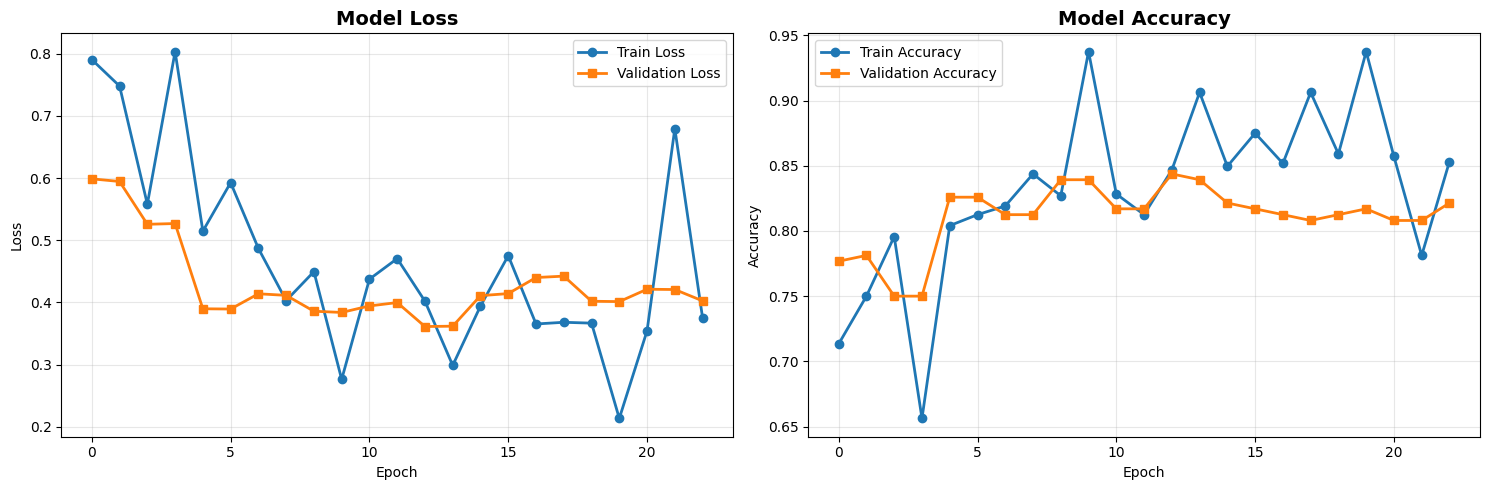

In [16]:
# Créer les graphiques d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, 'training_history_plot.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f" Graphique sauvegardé: {plot_path}")
plt.show()


## Résumé des performances

In [18]:
# Afficher un résumé des performances
print("\n" + "="*70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*70)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print(f"   - Epochs effectués: {len(history.history['loss'])}")
print(f"   - Meilleure validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) - Epoch {best_epoch}")
print(f"   - Accuracy finale (train): {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   - Accuracy finale (validation): {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   - Loss finale (train): {history.history['loss'][-1]:.4f}")
print(f"   - Loss finale (validation): {history.history['val_loss'][-1]:.4f}")

# Afficher le learning rate final si disponible
if 'lr' in history.history:
    final_lr = history.history['lr'][-1]
    print(f"   - Learning rate final: {final_lr:.2e}")

print("="*70)
print(f"\n Modèle sauvegardé dans: {MODEL_SAVE_PATH}")



RÉSUMÉ DE L'ENTRAÎNEMENT
   - Epochs effectués: 23
   - Meilleure validation accuracy: 0.8438 (84.38%) - Epoch 13
   - Accuracy finale (train): 0.8532 (85.32%)
   - Accuracy finale (validation): 0.8214 (82.14%)
   - Loss finale (train): 0.3752
   - Loss finale (validation): 0.4026

 Modèle sauvegardé dans: results/model_xception_best.h5
